# 导入相关包并可视化库存衰减曲线

In [1]:
from collections import namedtuple
from functools import partial
import math
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import random

%matplotlib inline

In [2]:
# 仓库库存与时刻、初始库存、衰减系数的关系
def decay(t, v_init, lam):
    """仓库stock level衰减方程"""
    return v_init * np.exp(-lam * t)

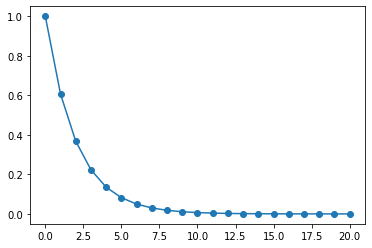

In [3]:
# 生成一个衰减参数确定的函数
decay0 = partial(decay, v_init=1, lam=0.5)

# 画出衰减曲线
t = np.arange(0, 21, 1)
plt.plot(t, decay0(t), marker="o")

# 解题思路
原点O和A、B、C、D、E五个warehouse可以组成6个位置。每次由原点O出发，遍历五个仓库之后，形成一条路径，所有这样的路径中存在至少一条路径使得卡车按照此路径行驶时的装载总量最大。      
我们以原点O为根节点，按照深度优先或广度优先的方式派生出所有的访问路径，也就是得到一棵生成树spanning tree，树中任意连接的父子两节点表示由父节点行驶至子节点，每次遍历到一个叶子节点时，可以计算出该路径上卡车的总装载量，总装载量最大时对应的路径即为最优路径。
# 伪代码
以深度优先方式为例，算法伪代码如下：
* 深度优先遍历DFS:
```
1: warehouse = set(A, B, C, D, E)  # 仓库集合   
2: max_volume = 0  # 卡车最大可pickup的量   
3: opt_path = None  # 最大可运载路线，待求解   
4: ST = tree consisting only of the origin vertex O  # 生成树ST，根节点为原点O   
5: visit(O)  # 从根节点开始遍历，构建生成树ST   
6: ouput max_volume and opt_path   
```
* Procedure `visit(v)`:  
```
1: for warehouse in warehouses:   
2:   if warehouse not exist in the path:   
3:     generate a new vertex w for the warehouse, add w and edge {v, w} to ST.   
4:     compute total_volume from O to w.   
5:       if w is a left vertex and total_volume > max_volume:   
6:         max_volume = total_volume   
7:         opt_path = path from O to w   
8:       else:   
9:         visit(w) 
```

# 算法实现与仿真

In [4]:
'''
两个主要的数据类，仓库和节点
仓库有位置和唯一名称属性。   
节点为生成树中的一个节点，包括：
唯一名称、父节点、子节点（列表）、仓库、到达时刻、到达该节点后卡车的总运载量
'''
Warehouse = namedtuple("Warehouse", ["x", "y", "name"])
Vertex = namedtuple("Vertex", ["name", "parent", "children", "warehouse", "time", "total_volume"])

In [5]:
# 随机生成五个仓库的函数
def random_warehouse(a, b, seed=None):
    '''随机生成五个仓库.
    
    Args:
      a, 仓库位置x轴上限；
      b, 仓库位置y轴上限；
      seed, 随机种子，默认None，当希望每次产生相同的仓库序列时设置该值为一个具体数值。
    Return:
      list[Warehouse], 位置随机的五个仓库。
    '''
    if seed is not None:
        random.seed(seed)
    return [Warehouse(
                      random.randint(a, b),
                      random.randint(a, b),
                      name)
            for name in ["A", "B", "C", "D", "E"]]

In [6]:
# 系统常量
V0 = 10  # initial stock level
VS = 100  # speed of truck
LAMBDA = 1  # lambda, decay factor
decay_func = partial(decay, v_init=V0, lam=LAMBDA)  # 生成一个具体的库存衰减函数

In [7]:
# 卡车行驶用时和到达某仓库时的库存计算函数

def spend(v, w):
    '''计算从节点v到达节点w需要的时长.'''
    x1, y1 = v.warehouse.x, v.warehouse.y
    x2, y2 = w.x, w.y
    return math.sqrt((x1-x2)**2 + (y1-y2)**2) / VS

def compute_stock_level(t):
    '''计算时刻t时仓库的库存.'''
    return decay_func(t)

In [8]:
def is_not_parents_and_children(w, v):
    '''判定节点w是否已经出现在节点v所在的路径上.'''
    if w.name in [child.warehouse.name for child in v.children]:
        return False
    if w.name == v.warehouse.name:
        return False
    while v.parent is not None:
        v = v.parent
        if v.warehouse.name == w.name:
            return False
    return True

def get_path_vertex_number(w):
    '''计算节点w所在路径的节点数量.'''
    number = 1
    while w.parent is not None:
        w = w.parent
        number += 1
    return number

def get_path(w):
    '''回溯并返回叶子节点w所在的路径.'''
    path = [w.warehouse.name]
    while w.parent is not None:
        w = w.parent
        path.append(w.warehouse.name)
    return path[::-1]
    
def visit(v):
    '''访问生成树中的节点v.
    
    访问节点v，查看节点v在树中的路径，如果一个仓库未出现在该路径上，
    则基于该仓库生成新的节点w和边{v, w}，然后递归访问新的子节点w.
    在递归过程中，每次到达叶子节点时，计算该路径上的卡车装载量，
    如果装载量最大，则更新最大装载量和最优路径。'''
    for w in warehouses:
        if is_not_parents_and_children(w, v):
            global node_counter
            tw = v.time + spend(v, w)
            total_volume = v.total_volume + compute_stock_level(tw)
            w = Vertex(w.name+str(node_counter), v, [], w, tw, total_volume)
            node_counter += 1
            v.children.append(w)
            G.add_edge(v.name, w.name)  # 可视化的图上新加一条边，可删除
            if get_path_vertex_number(w) < len(warehouses)+1:  # 还未到达叶子节点
                visit(w)
            else:  # 到达一个叶子节点
                global max_volume
                global opt_path
                wpath = get_path(w)
                # print(f"path: {wpath},\tvolume:{w.total_volume}")
                if w.total_volume > max_volume:
                    max_volume = w.total_volume
                    opt_path = wpath

## 仿真

In [9]:
# 全局变量
node_counter = 0  # 图中节点命名计数
max_volume = 0  # 最大可运载量
opt_path = None  # 最优路径，即运载量最大的路径

# 随机生成五个仓库，从原点以深度优先的方式遍历、生成所有路径，给出最优路径
warehouses = random_warehouse(0, 100, seed=None)
origin = Vertex("O", None, [], Warehouse(0, 0, "O"), 0, 0)
ST = origin
G = nx.Graph()  # 可视化用的图
G.add_node(origin.name)
visit(origin)

# 输出卡车最大装载量和路径
max_volume, opt_path

(18.743333088118064, ['O', 'B', 'D', 'E', 'A', 'C'])

# 可视化生成的树/图
以圆形的形式可视化生成的树，圆心节点为根节点O，每个节点的标签为**仓库名称+访问序号**

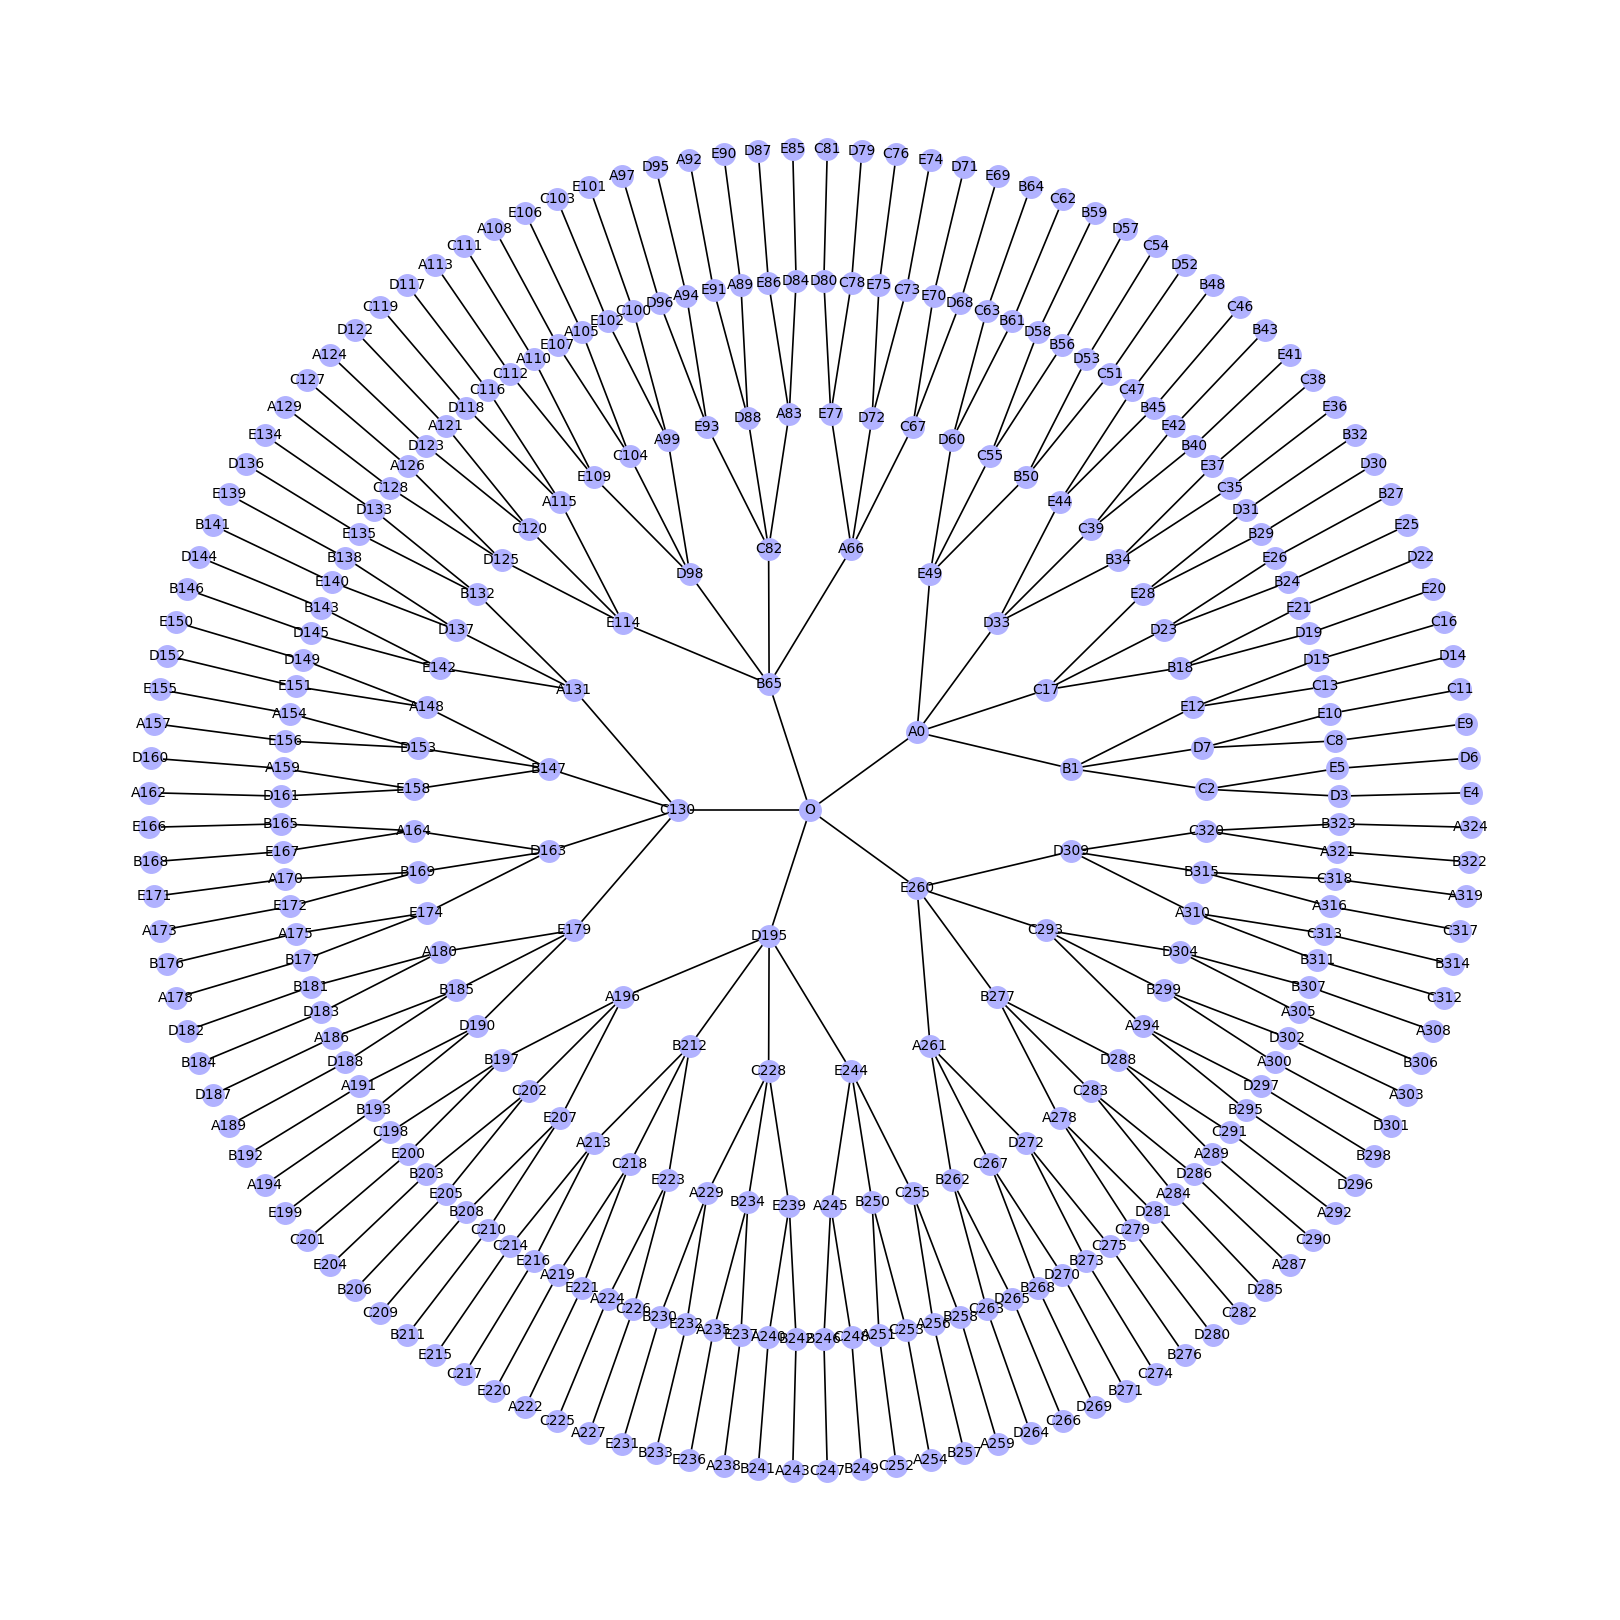

In [10]:
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

fig = plt.figure(1, figsize=(16, 16), dpi=100)
pos = graphviz_layout(G, prog="twopi")
nx.draw(G, pos, with_labels=True, node_color='#B1B2FF', node_size=240, width=1.2, font_size=10, font_color='k')
plt.show()

# 可视化最优路径

In [11]:
def plot_path(optimal_path, warehouses):
    last_warehouse = Warehouse(0, 0, "O")
    max_x, max_y = 0, 0
    for p in optimal_path[1:]:
        for w in warehouses:
            if w.name == p:
                plt.plot(w.x, w.y, marker="*", markersize=14)
                plt.plot((last_warehouse.x, w.x), (last_warehouse.y, w.y), "k-", markersize=14)
                plt.text(w.x, w.y+3, s=w.name)
                last_warehouse = w
                max_x = w.x if w.x > max_x else max_x
                max_y = w.y if w.y > max_y else max_y
    plt.plot(0, 0, marker="o", markersize=14)
    plt.xlim(-2, max_x + 4)
    plt.ylim(-5, max_y + 10)
    plt.show()

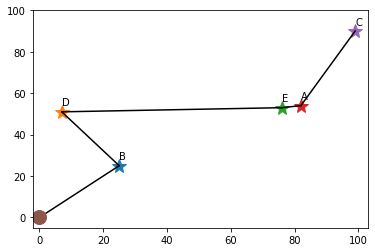

In [12]:
plot_path(opt_path, warehouses)